In [34]:
"Initialize"
%load_ext autoreload
%autoreload
%matplotlib widget
import matplotlib.pyplot as plt
import phaseco as pc
from helper_funcs import *
import os
# Replace this with the path to your otocoherence repo
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\otocoherence")


# Folders
figures_folder = os.path.join('results', 'figures', 'main')
pkl_folder = os.path.join('pickles', 'soae')
tau_pkl_folder = 'pickles'
os.makedirs(figures_folder, exist_ok=True)

# Global params
dpi=500


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
"Figure 1 (Processing)"
# Load wf
wf_fn = 'ACsb24rearSOAEwfA1.mat'
wf, _, fs, _, _ = get_wf(wf_fn)
# Preprocess
wf-=np.mean(wf)
wf=kaiser_filter(wf, fs, cf=150, df=100, rip=100)
# import scipy
# sos = scipy.signal.butter(6, 150,'hp',fs=fs,output='sos')
# wf = scipy.signal.sosfilt(sos, wf)
# Load noise floor
nf_fp = os.path.join('data', 'testSOAEsupp1.txt')   # file name
nf_data = np.loadtxt(nf_fp)
f_nf = nf_data[:,0]
mags_nf = nf_data[:,1]
# Params
tau = 1024
tau_hr = 3528
xi = 128
hop = 441
freq_bin_hop = 1 # For C_omega^phi

win = 'boxcar'
win_meth = {'method':'static', 'win_type':win}
# Calculate magnitude spectrum (avg_exp=1) and high res version
f, mags = get_welch(wf, fs, tau, avg_exp=1, hop=hop, win=win) 
f_hr, mags_hr = get_welch(wf, fs, tau_hr, avg_exp=1, hop=hop, win=win)
# Convert to dB
mags, mags_hr = 20*np.log10(mags), 20*np.log10(mags_hr)
# Calculate avg'd phases and autocoherences
C_xi_phi_dict = get_autocoherence(wf, fs, xi=xi, tau=tau, win_meth=win_meth, mode='phi', ref_type='time', return_pd=True, return_dict=True)
C_tau_phi_dict = get_autocoherence(wf, fs, xi=tau, tau=tau, win_meth=win_meth, mode='phi', ref_type='time', return_pd=True, return_dict=True)
C_omega_phi_dict = get_autocoherence(wf, fs, xi=xi, tau=tau, win_meth=win_meth, mode='phi', ref_type='freq', freq_bin_hop=1, return_pd=True, return_dict=True)
# Extract autocoherences
C_xi_phi = C_xi_phi_dict['autocoherence']
C_tau_phi = C_tau_phi_dict['autocoherence']
C_omega_phi = C_omega_phi_dict['autocoherence']
# and <|Delta phi|>
avg_abs_pd_xi = C_xi_phi_dict['avg_abs_pd']
avg_abs_pd_tau = C_tau_phi_dict['avg_abs_pd']
avg_abs_pd_omega = C_omega_phi_dict['avg_abs_pd']
# Omega frequency array is shifted
f_omega = C_omega_phi_dict['f']


Filtering wf with cf=150Hz, df=100Hz, rip=100dB
Filtering took 4.567s


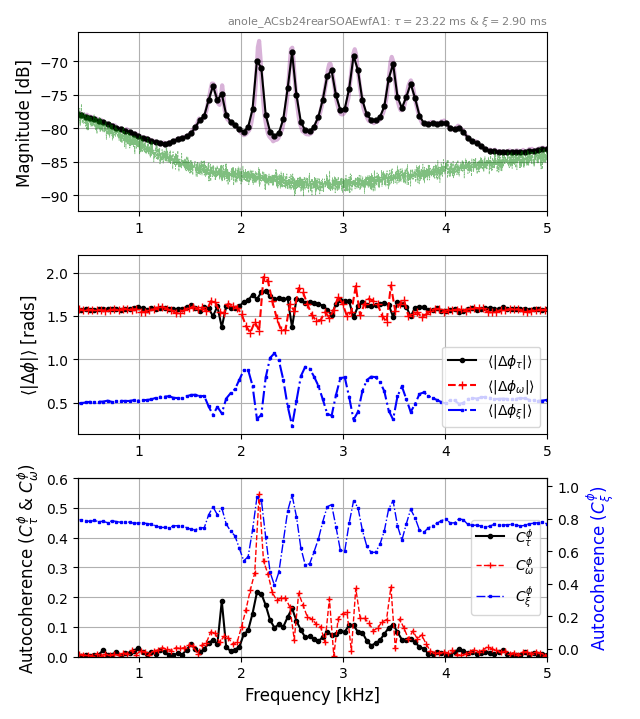

In [36]:
"Figure 1 (Plot)"
# Plotting parameters
markA='.'  # C_tau
markB='+'  # C_omega
markC='s'  # C_xi 
# freq. limits for plotting [kHz]
fmin, fmax = 0.4, 5
fmin_idx, fmax_idx = np.argmin(np.abs(f-fmin*3000)), np.argmin(np.abs(f-fmax*3000))
title = rf"anole_{wf_fn[:-4]}: $\tau={1000*tau/fs:.2f}$ ms & $\xi={1000*xi/fs:.2f}$ ms"
yoff_hr = 5.5 # Shift highres mags' "floating" dB scale up to line things up
yoff_nf = -60.5 # Shift noisefloor mags' "floating" dB scale up to line things up
micNF = 0.5
ylim_pad=[6,3] # Ylimit padding below/above mags on ylimits
ylims_left = [0, 0.6]

# Initialize plot
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(6.4, 4.8 * 1.5))

"Magnitude Subplot"
ax[0].plot(f_hr/1000,mags_hr+yoff_hr,linestyle='-', lw=3,
                color='purple',alpha=0.3,label='Avg. Magnitude (High Res.)')
# === mags. on top
ax[0].plot(f/1000,mags,linestyle='-', marker=markA, 
                ms=7,color='k',label='Avg. Magnitude')

# -- include mic noise floor
ax[0].plot(f_nf/1000,mags_nf+yoff_nf,linestyle='--',color='g',lw=micNF,
            alpha=0.5,label='Est. Noise Floor')
#
#ax5[0].set_xlabel('Frequency [kHz]')  
fracLS= 0.05  # scaling fraction to help w/ vert. lims {0.05}
ax[0].set_ylabel('Magnitude [dB]',fontsize=12)
ax[0].set_title(title,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
ax[0].set_xlim(fmin, fmax)
# ax[0].legend(loc="upper right")
ax[0].grid()
ax[0].set_ylim([np.min(mags[fmin_idx:(fmax_idx+1)])-ylim_pad[0],
                np.max(mags[fmin_idx:(fmax_idx+1)])+ylim_pad[1]])

"<|Delta phi|> Subplot"
ax[1].plot(f/1000,avg_abs_pd_tau,linestyle='-',marker=markA, 
                color='k',label=r'$\langle|\Delta \phi_\tau|\rangle$')
ax[1].plot(f_omega/1000,avg_abs_pd_omega,linestyle='--',marker=markB, 
                color='r',label=r'$\langle|\Delta \phi_\omega|\rangle$')
ax[1].plot(f/1000,avg_abs_pd_xi,linestyle='-.',marker=markC, 
                color='b',label=r'$\langle|\Delta \phi_\xi|\rangle$',markersize=2)
ax[1].set_ylabel(r"$\langle|\Delta \phi|\rangle$ [rads]",fontsize=12) 
ax[1].legend(loc="lower right")
ax[1].grid()
ax[1].set_xlim(fmin, fmax)

"Autocoherence Subplot"
# ===  coherence on bottom
Lb1= ax[2].plot(f/1000,C_tau_phi,linestyle='-', 
                marker=markA,color='k',label=r'$C_\tau^\phi$')
Lb2= ax[2].plot(f_omega/1000, C_omega_phi,'r',lw=1,linestyle='--',
                marker=markB,label=r'$C_\omega^\phi$',markersize=4)
# --- use right y-axis for C_xi
ax5b = ax[2].twinx()
Lb3= ax5b.plot(f/1000,C_xi_phi,'b',lw=1,linestyle='-.',
                marker=markC,label=r'$C_\xi^\phi$',markersize=2)
# same axis limits on both sides
ax5b.set_ylim([-0.05,1.05])
ax[2].set_xlabel('Frequency [kHz]',fontsize=12)  
ax[2].set_ylabel(r'Autocoherence ($C_\tau^\phi$ & $C_\omega^\phi$)',fontsize=12) 
ax5b.set_ylabel(r'Autocoherence ($C_{\xi}^\phi$)',fontsize=12,color='b') 
ax[2].grid()
ax[2].set_xlim(fmin, fmax)
ax[2].set_ylim(ylims_left)
LbT = Lb1+Lb2+Lb3  # deal w/ legend given multiple ordinates
labelF5 = [l.get_label() for l in LbT]
ax[2].legend(LbT,labelF5,loc="center right")
plt.tight_layout()
plt.savefig(os.path.join(figures_folder, 'Fig1.jpg'), dpi=dpi, bbox_inches='tight')



For JIrearSOAEwf2.mat we use [2339 4051 5838 8309]
Filtering wf with cf=150Hz, df=100Hz, rip=100dB
Filtering took 4.683s
Processing 'pickles\soae\Human 1, mode=phi, rho=1.0, Flattop, hop=441, tau=3285, filter=None, xi_max=1000ms, nfft=16384, N_pd=max, DM=True, wf_len=60s, wf=JIrearSOAEwf2 (Colossogram).pkl'
For owl_TAG4learSOAEwf1.mat we use [4945 5768 7184 9633]
Filtering wf with cf=150Hz, df=100Hz, rip=100dB
Filtering took 4.594s
Processing 'pickles\soae\Owl 3, mode=phi, rho=1.0, Flattop, hop=441, tau=3285, filter=None, xi_max=100ms, nfft=16384, N_pd=max, DM=True, wf_len=60s, wf=owl_TAG4learSOAEwf1 (Colossogram).pkl'
For AC6rearSOAEwfB1.mat we use [1235 2153 3704 4500]
Filtering wf with cf=150Hz, df=100Hz, rip=100dB
Filtering took 4.692s
Processing 'pickles\soae\Anole 0, mode=phi, rho=1.0, Flattop, hop=441, tau=3285, filter=None, xi_max=100ms, nfft=16384, N_pd=max, DM=True, wf_len=60s, wf=AC6rearSOAEwfB1 (Colossogram).pkl'


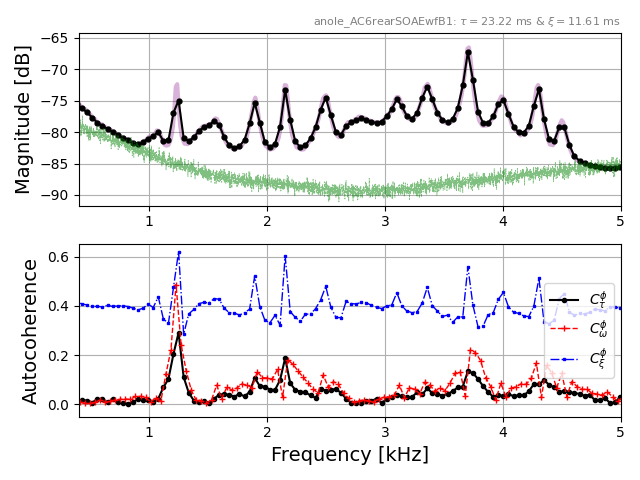

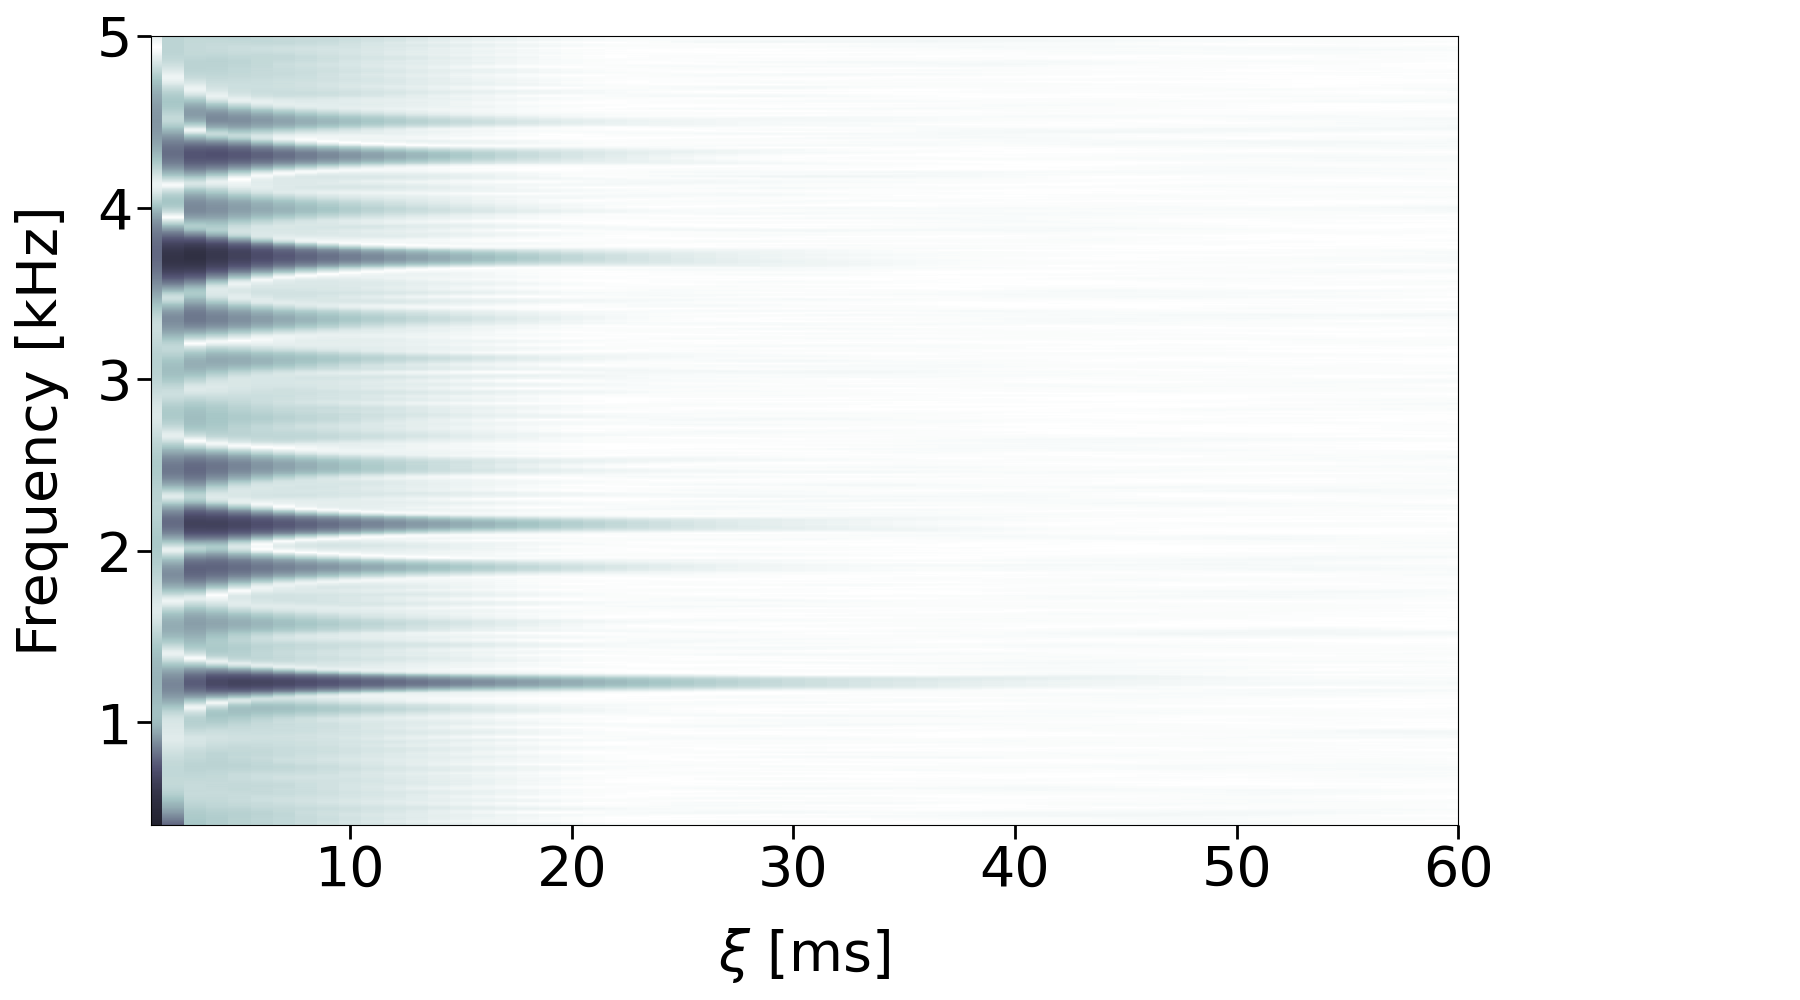

In [37]:
"Figure 2"
subjects = [('Human', 1), ('Owl', 3), ('Anole', 0)]
flims = {'Human':(0.4, 10), 'Owl':(2, 11), 'Anole':(0.4, 5)}
yoff_hrs = {'Human':2.5, 'Owl':5.5, 'Anole':5.5}
yoff_nfs = {'Human':-66, 'Owl':-61.5, 'Anole':-61.5}
taus = {'Human':2048, 'Owl':1024, 'Anole':1024,}
xis = {'Human':1024, 'Owl':512, 'Anole':512,}
Cmins = {'Human':-0.05, 'Owl':-0.05, 'Anole':-0.05}
Cmin_xis = {'Human':-0.05, 'Owl':-0.05, 'Anole':-0.05}
Cmaxs = {'Human':1.05, 'Owl':0.9, 'Anole':0.65}
Cmax_xis = {'Human':1.05, 'Owl':1.05, 'Anole':0.65}
# Colossogram
xi_max_ss = {'Human':1.0, 'Owl':0.1, 'Anole':0.1}
cgram_xmaxs = {'Human':1000, 'Owl':100, 'Anole':60}
# Plotting parameters
markA='.'  # C_tau
markB='+'  # C_omega
markC='s'  # C_xi 
fontsize_ac = 14
# Colossogram params
fontsize_cgram = 40
labelpad = 20
fontsize_ticks = 20

# Load noise floor
nf_fp = os.path.join('data', 'testSOAEsupp1.txt')   # file name
nf_data = np.loadtxt(nf_fp)
f_nf = nf_data[:,0]
mags_nf = nf_data[:,1]

# Global params
bw = 50
tau_hr = 3528
hop = 441
freq_bin_hop = 1
mode = 'phi'
win = 'boxcar'
win_meth = {'method':'static', 'win_type':'boxcar'}
win_type_cgram = 'flattop'
win_meth_cgram = {'method':'rho', 'rho':1.0, 'win_type':win_type_cgram}
lcc_kwargs = {
    "wf_len_s": 60,
    "filter_meth": None,
    "mode":'phi',
    "xi_min_s": 0.001,
    "win_meth": win_meth_cgram,
    "nfft": 2**14,
    "pkl_folder": pkl_folder,
}
for (species, wf_idx) in subjects:
    "First two rows"
    # Get waveform
    wf, wf_fn, fs, good_peak_freqs, _ = get_wf(species=species, wf_idx=wf_idx)
    print(f"For {wf_fn} we use {good_peak_freqs}")
    # Preprocess
    wf-=np.mean(wf)
    wf=kaiser_filter(wf, fs, cf=150, df=100, rip=100)

    # Get each subject specific param
    flim = flims[species]
    yoff_hr = yoff_hrs[species] # Shift highres mags' "floating" dB scale up to line things up
    yoff_nf =  yoff_nfs[species] # Shift noisefloor mags' "floating" dB scale up to line things up
    Cmax = Cmaxs [species]
    Cmax_xi = Cmax_xis [species]
    Cmin = Cmins [species]
    Cmin_xi = Cmin_xis [species]
    tau = taus[species]
    xi = xis[species]

    # Calculate magnitude spectrum (avg_exp=1) and high res version
    f, mags = get_welch(wf, fs, tau, avg_exp=1, hop=hop, win=win) 
    f_hr, mags_hr = get_welch(wf, fs, tau_hr, avg_exp=1, hop=hop, win=win)
    # Convert to dB
    mags, mags_hr = 20*np.log10(mags), 20*np.log10(mags_hr)
    # Calculate autocoherences
    C_xi_phi = get_autocoherence(wf, fs, xi=xi, tau=tau, win_meth=win_meth, mode='phi', ref_type='time')[1]
    C_tau_phi = get_autocoherence(wf, fs, xi=tau, tau=tau, win_meth=win_meth, mode='phi', ref_type='time')[1]
    f_omega, C_omega_phi = get_autocoherence(wf, fs, xi=xi, tau=tau, win_meth=win_meth, mode='phi', ref_type='freq', freq_bin_hop=1)
    
    # freq. limits for plotting [kHz]
    fmin, fmax = flim[0], flim[1]
    fmin_idx, fmax_idx = np.argmin(np.abs(f-fmin*1000)), np.argmin(np.abs(f-fmax*1000))
    if species!= 'Owl':
        title = rf"{species.lower()}_{wf_fn[:-4]}: $\tau={1000*tau/fs:.2f}$ ms & $\xi={1000*xi/fs:.2f}$ ms"
    else:
        title = rf"{wf_fn[:-4]}: $\tau={1000*tau/fs:.2f}$ ms & $\xi={1000*xi/fs:.2f}$ ms"

    ylim_pad=[6,3] # Ylimit padding below/above mags on ylimits

    # Initialize plot
    plt.close('all')
    fig, ax = plt.subplots(2, 1, figsize=(6.4, 4.8))

    "Magnitude Subplot"
    ax[0].plot(f_hr/1000,mags_hr+yoff_hr,linestyle='-', lw=3,
                    color='purple',alpha=0.3,label='Avg. Magnitude (High Res.)')
    # === mags. on top
    ax[0].plot(f/1000,mags,linestyle='-', marker=markA, 
                    ms=7,color='k',label='Avg. Magnitude')

    # -- include mic noise floor
    ax[0].plot(f_nf/1000,mags_nf+yoff_nf,linestyle='--',color='g',lw=0.5,
                alpha=0.5,label='Est. Noise Floor')
    #
    #ax5[0].set_xlabel('Frequency [kHz]')  
    fracLS= 0.05  # scaling fraction to help w/ vert. lims {0.05}
    ax[0].set_ylabel('Magnitude [dB]',fontsize=fontsize_ac)
    ax[0].set_title(title,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    ax[0].set_xlim(fmin, fmax)
    # ax[0].legend(loc="upper right")
    ax[0].grid()
    ax[0].set_ylim([np.min(mags[fmin_idx:(fmax_idx+1)])-ylim_pad[0],
                    np.max(mags[fmin_idx:(fmax_idx+1)])+ylim_pad[1]])


    "Autocoherence Subplot"
    # ===  coherence on bottom
    Lb1= ax[1].plot(f/1000,C_tau_phi,linestyle='-', 
                    marker=markA,color='k',label=r'$C_\tau^\phi$')
    Lb2= ax[1].plot(f_omega/1000, C_omega_phi,'r',lw=1,linestyle='--',
                    marker=markB,label=r'$C_\omega^\phi$',markersize=4)
    # --- use right y-axis for C_xi
    # ax5b = ax[1].twinx()
    # Lb3= ax5b.plot(f/1000,C_xi_phi,'b',lw=1,linestyle='-.', marker=markC,label=r'$C_\xi^\phi$',markersize=2)
    Lb3 = ax[1].plot(f/1000,C_xi_phi,'b',lw=1,linestyle='-.',
                    marker=markC,label=r'$C_\xi^\phi$',markersize=2)

    # same axis limits on both sides
    # ax5b.set_ylim([Cmin_xi,Cmax_xi])
    ax[1].set_xlabel('Frequency [kHz]',fontsize=fontsize_ac)  
    # ax[1].set_ylabel(r'Autocoherence ($C_\tau^\phi$ & $C_\omega^\phi$)',fontsize=fontsize_ac) 
    ax[1].set_ylabel(r'Autocoherence',fontsize=fontsize_ac) 
    # ax5b.set_ylabel(r'Autocoherence ($C_{\xi}^\phi$)',fontsize=12,color='b') 
    ax[1].grid()
    ax[1].set_xlim(fmin, fmax)
    ax[1].set_ylim([Cmin,Cmax])
    LbT = Lb1+Lb2+Lb3  # deal w/ legend given multiple ordinates
    labelF5 = [l.get_label() for l in LbT]
    ax[1].legend(LbT,labelF5,loc="center right")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_folder, f'Fig2R1 ({species}).jpg'), dpi=dpi, bbox_inches='tight')

    "Colossogram Plot"
    # Get waveform
    wf, wf_fn, fs, _, _ = get_wf(species=species, wf_idx=wf_idx)
    # Preprocess
    wf-=np.mean(wf)
    tau_cgram = get_precalc_tau_from_bw(bw, fs, win_type_cgram, tau_pkl_folder)
    # Load Colossogram
    cgram_dict = load_calc_colossogram(
        **(
            lcc_kwargs
            | {
                "xi_max_s": xi_max_ss[species],
                "species": species,
                "fs": fs,
                "tau": tau_cgram,
                "hop": hop,
                "wf": wf,
                "wf_idx": wf_idx,
                "wf_fn": wf_fn,
            }
        )
    )


    # Load everything that wasn't explicitly "saved" in the filename
    colossogram = cgram_dict["colossogram"]
    fn_id = cgram_dict["fn_id"]
    win_meth_str = cgram_dict["win_meth_str"]
    method_id = cgram_dict["method_id"]
    filter_str = cgram_dict["filter_str"]
    f = cgram_dict["f"]
    xis_s = cgram_dict["xis_s"]
    # good_peak_idxs = np.argmin(np.abs(f[:, None] - good_peak_freqs[None, :]), axis=0)
    # method_id = rf"[$\tau$={(tau/fs)*1000:.2f}ms]   [Mode=$\phi$]   [{win_meth_str}]   [Hop={hop_s*1000:.1f}ms]   [{N_pd_str}]   [nfft={nfft}]"
    suptitle = (
        rf"[{species} {wf_idx}]   [{wf_fn}]   [HPBW={bw}Hz]   {method_id}   [{filter_str}]"
    )

    # MAKE PLOT
    plt.figure(figsize=(18, 10))
    cbar = pc.plot_colossogram(cgram_dict, cmap="bone_r", return_cbar=True)
    # Set Chris' requested fontsizes
    ax = plt.gca()
    ax.set_xlabel(r"$\xi$ [ms]", labelpad=labelpad, fontsize=fontsize_cgram)
    ax.set_ylabel("Frequency [kHz]", labelpad=labelpad, fontsize=fontsize_cgram)
    ax.tick_params(axis='both', which='major', length=10, width=2)
    ax.tick_params("both", labelsize=fontsize_cgram)
    cbar.ax.yaxis.label.set_fontsize(fontsize_cgram)
    cbar.ax.tick_params(labelsize=fontsize_cgram)
    if species != 'Human':
        cbar.ax.remove()

    xmin = xis_s[0] * 1000
    xmax = cgram_xmaxs[species]
    plt.ylim(fmin, fmax)
    plt.xlim(xmin, xmax)

    # for f0_idx in good_peak_idxs:
    #     plt.scatter(
    #         xmin / 2,
    #         f[f0_idx] / 1000,
    #         c="purple",
    #         marker=">",
    #         label="Peak at " + f"{f[f0_idx]:0f}Hz",
    #         alpha=0.5,
    #         s=100
    #     )

    # plt.title(f"Colossogram", fontsize=18)
    # plt.suptitle(suptitle, fontsize=10)
    plt.tight_layout()
    plt.savefig(
        os.path.join(figures_folder, f"Fig2R2 ({species}).jpg"),
        dpi=dpi,
    )


    
    

Processing 'pickles\soae\Anole 0, mode=phi, rho=1.0, Flattop, hop=441, tau=3285, filter=None, xi_max=100ms, nfft=16384, N_pd=max, DM=True, wf_len=60s, wf=AC6rearSOAEwfB1 (Colossogram).pkl'
Initializing fit on 4500Hz autocoherence decay...
One peak found in first 26ms of xi, starting fit here
Fitting...
Fit succeeded on first try!


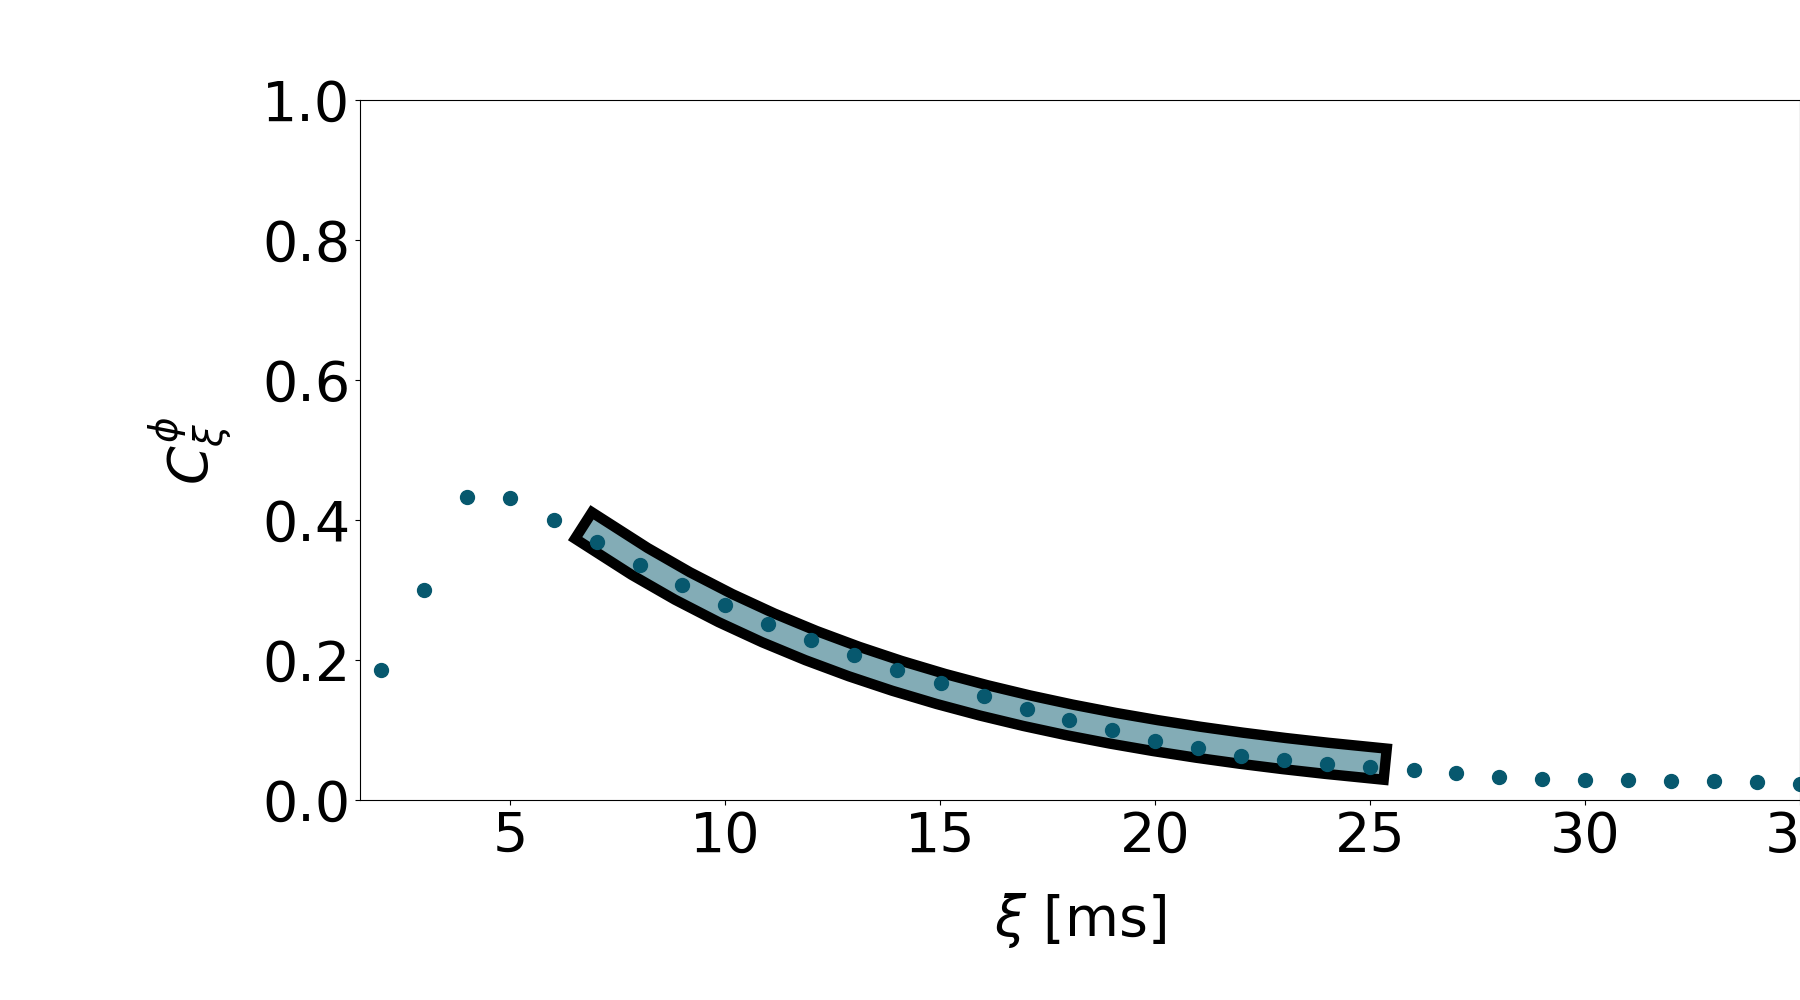

In [38]:
"Figure 3A (Anole)"

# Choose subject
species = "Anole"
wf_idx = 0


# Get waveform
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)

# Get/set a few more params
xi_max_s = 0.1
win_type = 'flattop'
hop = 441
tau = get_precalc_tau_from_bw(bw, fs, win_type, tau_pkl_folder)

# Colors
anole_color = "#07586E"

# Load Colossogram
cgram_dict = load_calc_colossogram(
    **(
        lcc_kwargs
        | {
            "xi_max_s": xi_max_s,
            "species": species,
            "fs": fs,
            "tau": tau,
            "hop": hop,
            "wf": wf,
            "wf_idx": wf_idx,
            "wf_fn": wf_fn,
        }
    )
)


# Load everything that wasn't explicitly "saved" in the filename
colossogram = cgram_dict["colossogram"]
fn_id = cgram_dict["fn_id"]
win_meth_str = cgram_dict["win_meth_str"]
method_id = cgram_dict["method_id"]
filter_str = cgram_dict["filter_str"]
# N_pd_str = pc.get_N_pd_str(const_N_pd, cgram_dict["N_pd_min"], cgram_dict["N_pd_max"])
f = cgram_dict["f"]
xis_s = cgram_dict["xis_s"]
good_peak_idxs = np.argmin(np.abs(f[:, None] - good_peak_freqs[None, :]), axis=0)
# method_id = rf"[$\tau$={(tau/fs)*1000:.2f}ms]   [Mode=$\phi$]   [{win_meth_str}]   [Hop={hop/fs*1000:.1f}ms]   [{N_pd_str}]   [nfft={nfft}]"
# suptitle = (
#     rf"[{species} {wf_idx}]   [{wf_fn}]   [HPBW={bw}Hz]   {method_id}   [{filter_str}]"
# )

# Get N_xi_fit
f0 = 4500

# Fitting Parameters
A_max = np.inf  # 1 or np.inf
A_const = False  # Fixes the amplitude of the decay at 1

N_xi, N_xi_dict = pc.get_N_xi(
    cgram_dict,
    f0,
)

# MAKE PLOT
fig = plt.figure(figsize=(18, 10))
ax = fig.add_axes([0.2, 0.2, 0.8, 0.7])  # [left, bottom, width, height] in figure fraction
pc.plot_N_xi_fit(N_xi_dict, color=anole_color, plot_noise_floor=False, lw_fit=15, lw_stroke=15, s_signal=100)


ax.set_xlabel(r"$\xi$ [ms]", labelpad=labelpad, fontsize=fontsize_cgram)
ax.set_ylabel(r"$C_\xi^\phi$", labelpad=labelpad, fontsize=fontsize_cgram)
ax.set_title("")
ax.legend(fontsize=fontsize_cgram-10)
ax.get_legend().remove()

ax.tick_params('both', labelsize=fontsize_cgram)

plt.xlim(1.5, 35)
    
# plt.title(f"Colossogram", fontsize=18)
# plt.suptitle(suptitle, fontsize=10)
# plt.tight_layout()
plt.savefig(os.path.join(figures_folder, f'Fig3A (Anole).jpg'), dpi=dpi, bbox_inches='tight')

Processing 'pickles\soae\Human 3, mode=phi, rho=1.0, Flattop, hop=441, tau=3285, filter=None, xi_max=1500ms, nfft=16384, N_pd=max, DM=True, wf_len=60s, wf=TH13RearwaveformSOAE (Colossogram).pkl'
Initializing fit on 904Hz autocoherence decay...
One peak found in first 376ms of xi, starting fit here
Fitting...
Fit succeeded on first try!


C:\Users\setht\AppData\Local\Temp\ipykernel_37272\235170701.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


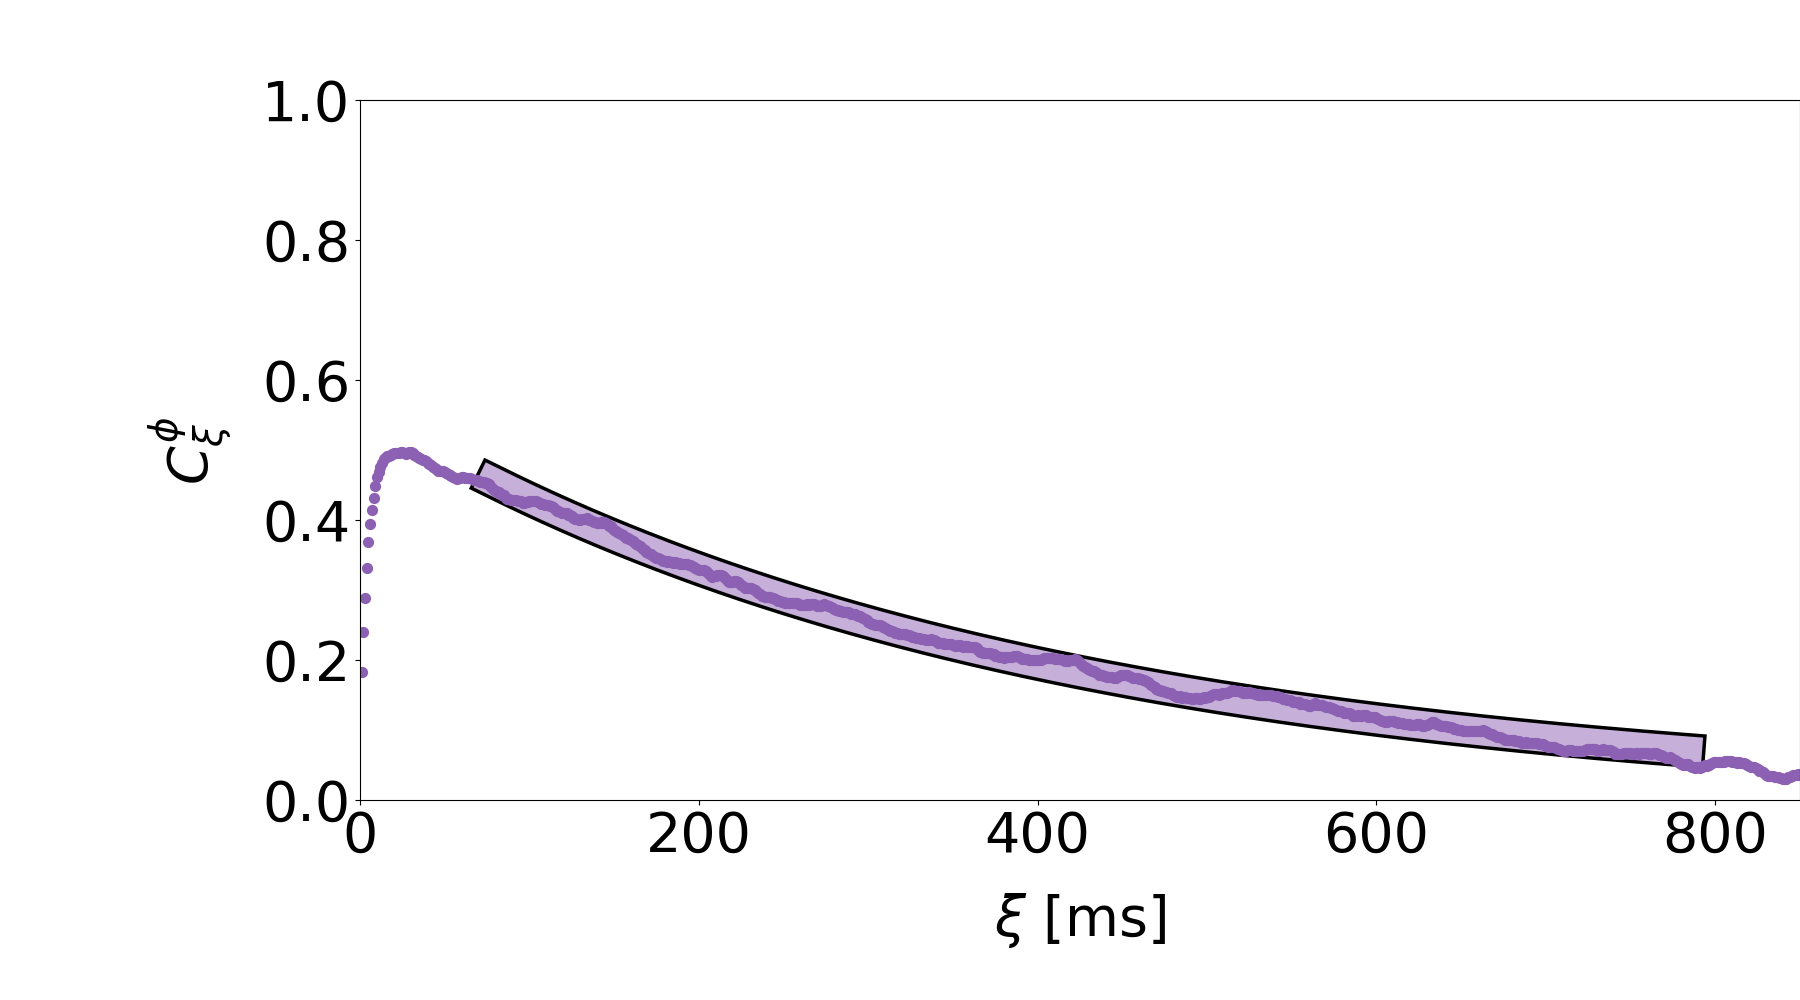

In [39]:
"Figure 3A (Human)"

# Choose subject
species = "Human"
wf_idx = 3
# Get waveform
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)

# Get/set a few more params
human_color = "#8C60B3"
xi_max_s = 1.5
bw = 50
win_type = 'flattop'
tau = get_precalc_tau_from_bw(bw, fs, win_type, tau_pkl_folder)

# Load Colossogram
cgram_dict = load_calc_colossogram(
    **(
        lcc_kwargs
        | {
            "xi_max_s": xi_max_s,
            "species": species,
            "fs": fs,
            "tau": tau,
            "hop": hop,
            "wf": wf,
            "wf_idx": wf_idx,
            "wf_fn": wf_fn,
        }
    )
)


# Load everything that wasn't explicitly "saved" in the filename
colossogram = cgram_dict["colossogram"]
fn_id = cgram_dict["fn_id"]
win_meth_str = cgram_dict["win_meth_str"]
method_id = cgram_dict["method_id"]
filter_str = cgram_dict["filter_str"]
# N_pd_str = pc.get_N_pd_str(const_N_pd, cgram_dict["N_pd_min"], cgram_dict["N_pd_max"])
f = cgram_dict["f"]
xis_s = cgram_dict["xis_s"]
good_peak_idxs = np.argmin(np.abs(f[:, None] - good_peak_freqs[None, :]), axis=0)
# method_id = rf"[$\tau$={(tau/fs)*1000:.2f}ms]   [Mode=$\phi$]   [{win_meth_str}]   [Hop={hop_s*1000:.1f}ms]   [{N_pd_str}]   [nfft={nfft}]"
suptitle = (
    rf"[{species} {wf_idx}]   [{wf_fn}]   [HPBW={bw}Hz]   {method_id}   [{filter_str}]"
)

# Get N_xi_fit
f0 = 904

# Fitting Parameters
A_max = np.inf  # 1 or np.inf
A_const = False  # Fixes the amplitude of the decay at 1

N_xi, N_xi_dict = pc.get_N_xi(
    cgram_dict,
    f0,
    A_max=A_max,
    A_const=A_const,
)



# MAKE PLOT
fig = plt.figure(figsize=(18, 10))
ax = fig.add_axes([0.2, 0.2, 0.8, 0.7])  # [left, bottom, width, height] in figure fraction
pc.plot_N_xi_fit(N_xi_dict, color=human_color, plot_noise_floor=False, s_signal=50, lw_fit=20, lw_stroke=5)


ax.set_xlabel(r"$\xi$ [ms]", labelpad=labelpad, fontsize=fontsize_cgram)
ax.set_ylabel(r"$C_\xi^\phi$", labelpad=labelpad, fontsize=fontsize_cgram)
ax.set_title("")
ax.legend(fontsize=fontsize_cgram-10)
ax.get_legend().remove()

ax.tick_params('both', labelsize=fontsize_cgram)

plt.xlim(0, 850)
    
# plt.title(f"Colossogram", fontsize=18)
# plt.suptitle(suptitle, fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(figures_folder, f'Fig3A (Human).jpg'),dpi=dpi, bbox_inches='tight')

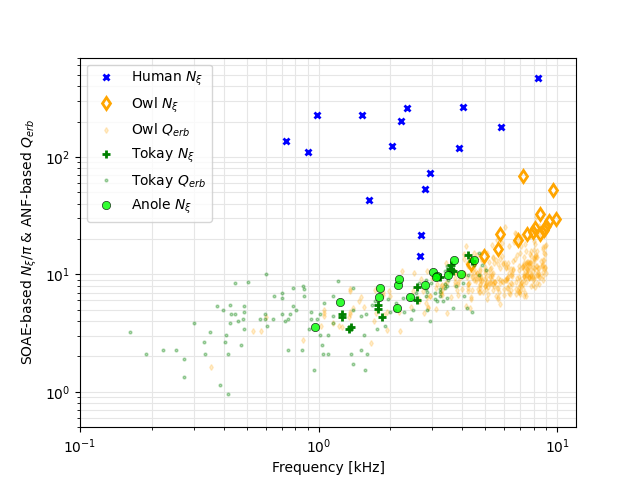

In [40]:
"Figure 3B"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
fp_N_xi= os.path.join('results','soae','SOAE Results (rho=1.0, Flattop, BW=50Hz, Mode=phi)', 'SOAE N_xi Fitted Parameters (rho=1.0, Flattop, BW=50Hz, Mode=phi).xlsx')

fact= 1/(np.pi);  # scaling factor for all Nxi {1/pi}

# --- owl ANF tuning curve data (Excel files provided by Christine)
fp_ANFfileOwl= os.path.join('data','Owl Qerb_analysis_CK2.xlsx')

fp_ANFfileTokay= os.path.join('data', 'manley99.txt')
# ======================================================


# --- read in data
df = pd.read_excel(fp_N_xi)
owlANF= pd.read_excel(fp_ANFfileOwl)
toakyANFq10 = np.loadtxt(fp_ANFfileTokay)

# ---------
# Get peak frequency and corresponding val to plot
anole_freqs = df[df['Species'] == 'Anole']['Frequency'].values
anole_Nxi = df[df['Species'] == 'Anole']['N_xi'].values
owl_freqs = df[df['Species'] == 'Owl']['Frequency'].values
owl_Nxi = df[df['Species'] == 'Owl']['N_xi'].values
human_freqs = df[df['Species'] == 'Human']['Frequency'].values
human_Nxi = df[df['Species'] == 'Human']['N_xi'].values

tokay_freqs = df[df['Species'] == 'Tokay']['Frequency'].values
tokay_Nxi = df[df['Species'] == 'Tokay']['N_xi'].values


# =========================
# deal w/ owl ANF vals
owlANF= owlANF[1:]  # discard first line
freqANFowl= owlANF['CF'].values
QerbANFowl= owlANF['Qerb'].values

# =========================
# deal w/ tokay ANF vals
freqANFtokay= toakyANFq10[:,0]
QerbANFtokay= 6*toakyANFq10[:,1]*1000/np.pi;  # convert to Qerb(?) via Bergevin & Shera 2010



# =======================================================================
# ==== visualize
plt.close("all")
# ------------------------------------------------
fig1, ax1 = plt.subplots()


# --- human
fig1= plt.plot(human_freqs/1000,human_Nxi*fact,'x',color='blue',
               alpha=1,ms=5,markeredgewidth=2,markerfacecolor='none',label=r'Human $N_{\xi}$')

# --- owl
fig1= plt.plot(owl_freqs/1000,owl_Nxi*fact,'d',color='orange',
               alpha=1.0,ms=6,markeredgewidth=2,markerfacecolor='none',label=r'Owl $N_{\xi}$')

fig1= plt.plot(freqANFowl,QerbANFowl,'d',color='orange',
               alpha=0.2,ms=3,lw=1,markerfacecolor='orange',label=r'Owl $Q_{erb}$')

# --- tokay
fig1= plt.plot(tokay_freqs/1000,tokay_Nxi*fact,'+',color='green',
               alpha=1,ms=6,markeredgewidth=2,markerfacecolor='none',label=r'Tokay $N_{\xi}$')
fig1= plt.plot(freqANFtokay,QerbANFtokay,'o',color='green',
               alpha=0.3,ms=2,lw=1,markerfacecolor='green',label=r'Tokay $Q_{erb}$')

# --- anole
fig1= plt.plot(anole_freqs/1000,anole_Nxi*fact,'o',color='k',markeredgewidth=0.5,
               alpha=0.8,ms=6,markerfacecolor='lime',label=r'Anole $N_{\xi}$')
# ---
ax1.set_xscale('log')
ax1.set_yscale('log')
fig1= plt.xlim([0.1,12])
fig1= plt.ylim([0.5,700])
fig1= plt.xlabel('Frequency [kHz]')
fig1= plt.ylabel(r'SOAE-based $N_{\xi}/\pi$ & ANF-based $Q_{erb}$') 
fig1= plt.grid(True, which="both", ls="-", color='0.9')
fig1= plt.legend()
if (1==0):
    fig1= plt.title('Comparison of Colossogram Time Constants and ANF-derived Tuning') 
fig_fp = os.path.join('results', 'figures', 'main', 'Fig3B')
plt.savefig(fig_fp, dpi=dpi, bbox_inches='tight')
plt.show()




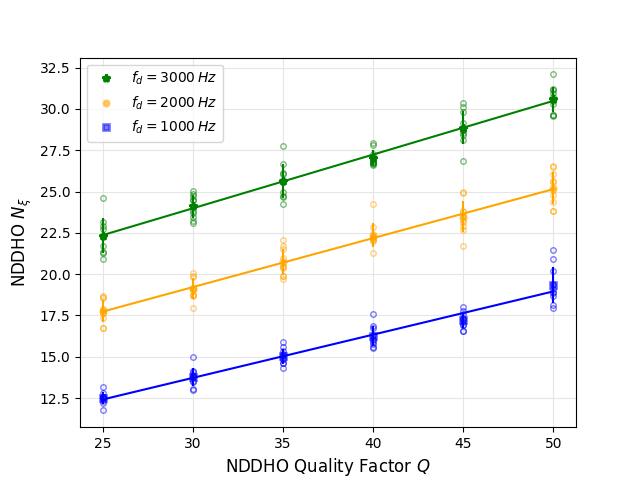

In [41]:
"Figure 3C"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# ======================================================
fp= os.path.join('results', 'nddho', 'NDDHO Results [rho=1.0, Flattop, BW=50Hz, Mode=phi, A_const=False]', 'NDDHO N_xi Data [rho=1.0, Flattop, BW=50Hz, Mode=phi, A_const=False].xlsx')
jitterA= 0
alpha=0.5
# ======================================================

# use a function to do the averaging from the Excel file
def compAVGs(arrA):
    aMean= np.mean(arrA[CF1000_Q==25])
    aSTD= np.std(arrA[CF1000_Q==25])
    bMean= np.mean(arrA[CF1000_Q==30])
    bSTD= np.std(arrA[CF1000_Q==30])
    cMean= np.mean(arrA[CF1000_Q==35])
    cSTD= np.std(arrA[CF1000_Q==35])
    dMean= np.mean(arrA[CF1000_Q==40])
    dSTD= np.std(arrA[CF1000_Q==40])
    eMean= np.mean(arrA[CF1000_Q==45])
    eSTD= np.std(arrA[CF1000_Q==45])
    fMean= np.mean(arrA[CF1000_Q==50])
    fSTD= np.std(arrA[CF1000_Q==50])
    avgs= [aMean,bMean,cMean,dMean,eMean,fMean]
    stds= [aSTD,bSTD,cSTD,dSTD,eSTD,fSTD]
    return np.array([avgs,stds],float)

# --- read in data
df = pd.read_excel(fp)
Qs= [25, 30, 35, 40, 45, 50]

# ----------------
# -- CF=1000 case
CF1000_Q = df[df['CF'] == 1000]['Q'].values
CF1000_Nxi = df[df['CF'] ==1000]['N_xi'].values
CF1000_NxiSTD = df[df['CF'] == 1000]['N_xi_std'].values
tmp= compAVGs(CF1000_Nxi)
CF1000_NxiMean= tmp[0,:]
CF1000_NxiSTD= tmp[1,:]
# -- CF=2000 case
CF2000_Q = df[df['CF'] == 2000]['Q'].values
CF2000_Nxi = df[df['CF'] == 2000]['N_xi'].values
CF2000_NxiSTD = df[df['CF'] == 2000]['N_xi_std'].values
tmp= compAVGs(CF2000_Nxi)
CF2000_NxiMean= tmp[0,:]
CF2000_NxiSTD= tmp[1,:]
# -- CF=3000 case
CF3000_Q = df[df['CF'] == 3000]['Q'].values
CF3000_Nxi = df[df['CF'] == 3000]['N_xi'].values
CF3000_NxiSTD = df[df['CF'] == 3000]['N_xi_std'].values
tmp= compAVGs(CF3000_Nxi)
CF3000_NxiMean= tmp[0,:]
CF3000_NxiSTD= tmp[1,:]


# ----------------
# linear regression fits
tmpFit= np.polyfit(Qs,CF1000_NxiMean,1)
tmpFit2= np.poly1d(tmpFit)
fit10P= tmpFit2(Qs)

tmpFit= np.polyfit(Qs,CF2000_NxiMean,1)
tmpFit2= np.poly1d(tmpFit)
fit100P= tmpFit2(Qs)

tmpFit= np.polyfit(Qs,CF3000_NxiMean,1)
tmpFit2= np.poly1d(tmpFit)
fit1000P= tmpFit2(Qs)


# =======================================================================
# ==== visualize
plt.close("all")
# ------------------------------------------------
fig1, ax1 = plt.subplots()

# --- CF=3000 case
fig1= plt.plot((CF3000_Q+jitterA*np.random.randn(1,len(CF3000_Q))).flatten(),CF3000_Nxi,
               '.',color='green',alpha=alpha,ms=2,markeredgewidth=4,markerfacecolor='none')
fig1= plt.plot(Qs,CF3000_NxiMean,'*',color='green',ms=6,
               label=r'$f_d={3000}\, Hz$',markeredgewidth=2)
fig1= plt.errorbar(Qs,CF3000_NxiMean,yerr=CF3000_NxiSTD,
                   fmt=' ',color='green')
fig1= plt.plot(Qs,fit1000P,'-',color='green')
# --- CF=2000 case
fig1= plt.plot((CF2000_Q+jitterA*np.random.randn(1,len(CF2000_Q))).flatten(),CF2000_Nxi,
               '.',color='orange',alpha=alpha,ms=2,markeredgewidth=4,markerfacecolor='none')
fig1= plt.plot(Qs,CF2000_NxiMean,'o',color='orange',ms=4,alpha=0.5,
               label=r'$f_d={2000}\, Hz$',markeredgewidth=2)
fig1= plt.errorbar(Qs,CF2000_NxiMean,yerr=CF2000_NxiSTD,
                   fmt=' ',color='orange')
fig1= plt.plot(Qs,fit100P,'-',color='orange')
# --- CF=1000 case
#fig1= plt.plot(CF10_Q,CF10_Nxi,'.',color='blue',
#               alpha=0.2,ms=2,markeredgewidth=4,markerfacecolor='none')
fig1= plt.plot((CF1000_Q+jitterA*np.random.randn(1,len(CF1000_Q))).flatten(),CF1000_Nxi,
               '.',color='blue',alpha=alpha,ms=2,markeredgewidth=4,markerfacecolor='none')
fig1= plt.plot(Qs,CF1000_NxiMean,'s',color='blue',ms=4,alpha=0.5,
               label=r'$f_d={1000}\, Hz$',markeredgewidth=2)
fig1= plt.errorbar(Qs,CF1000_NxiMean,yerr=CF1000_NxiSTD,
                   fmt=' ',color='blue')
fig1= plt.plot(Qs,fit10P,'-',color='blue')
# ---
fig1= plt.xlabel(r'NDDHO Quality Factor $Q$',fontsize=12)
fig1= plt.ylabel(r'NDDHO $N_{\xi}$',fontsize=12) 
fig1= plt.grid(True, which="both", ls="-", color='0.9')
fig1= plt.legend()
fp = os.path.join(figures_folder, 'Fig3C')
plt.savefig(fp, dpi=dpi, bbox_inches='tight')

C:\Users\setht\AppData\Local\Temp\ipykernel_37272\144719429.py:53: RuntimeWarning: invalid value encountered in log10
  mags_nf = 20 * np.log10(mags_nf)


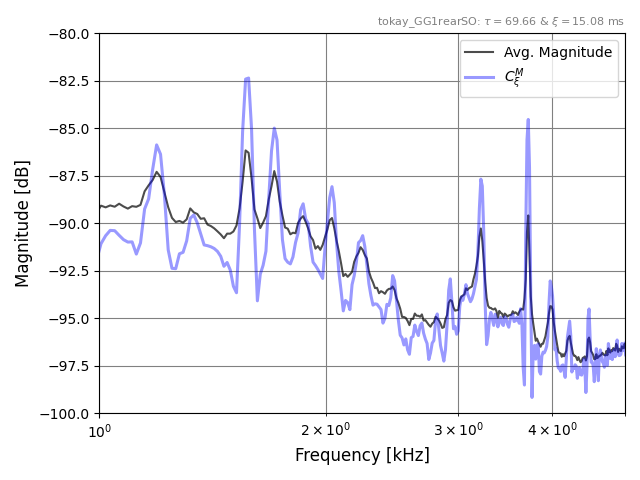

In [42]:
"Figure 4A"
import phaseco as pc
import scipy.io as sio
import os
import matplotlib.pyplot as plt
from helper_funcs import *
import scipy.signal as signal

# Filepaths
data_fp = "data"
wf_fn = "tokay_GG1rearSOAEwf"
fig_fp = os.path.join(figures_folder, f"Fig4A.jpg")

# Global Parameters
fs = 44100
tau = 3072
do_filter = True

# Coherence parameters
xi = 665
hop_C = 441
win_meth = {"method": "rho", "rho": 1.0, "win_type": "boxcar"}
# Pure magnitude parameters
hop_mags = 3072
win_mags = 'boxcar'


# Load noise floor
nf_fp = os.path.join('data', 'testSOAEsupp1.txt')   # file name
# nf_data = np.loadtxt(nf_fp)
# f_nf = nf_data[:,0]
# mags_nf = nf_data[:,1]


# Plotting params
s_tri = 20
tri_prop_from_top = 0.1
title= wf_fn[:-4]+": "+r'$ \tau=$'+f'{1000*tau/fs:.2f}'+" & "+r'$ \xi=$'+f'{1000*xi/fs:.2f}'+" ms"
# Offsets to line up noise floors; OK to add this offset because it's a "floating" dB scale
yoff_C_xi_M = -43.5 
yoff_nf = -90

wf = sio.loadmat(os.path.join(data_fp, wf_fn))["wf"][0]
f, C_xi_M = pc.get_autocoherence(
    wf, fs, xi, tau, hop=hop_C, nfft=tau, win_meth=win_meth, mode="M", ref_type="time"
)
mags = pc.get_welch(wf, fs, tau, nfft=tau, hop=hop_mags, win=win_mags, avg_exp=1)[1]


# Convert to dB and kHz
C_xi_M = 20 * np.log10(C_xi_M)
mags   = 20 * np.log10(mags)
mags_nf = 20 * np.log10(mags_nf)
f = f / 1000
# f_nf = f_nf



# Set limits
ymin = -100
ymax = -80
xmin = 1
xmax = 5

plt.close('all')
plt.subplots
# Plot spectra
plt.plot(f, mags, label="Avg. Magnitude", alpha=0.7, color="k")
plt.plot(f, C_xi_M + yoff_C_xi_M, label=r"$C_\xi^M$", color="blue", alpha=0.4, lw=2.2) 
# plt.plot(f_nf,mags_nf+yoff_nf,linestyle='--',color='g',lw=0.5,
#                 alpha=0.5,label='Est. Noise Floor')
# Set lims and labels
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.ylabel("Magnitude [dB]", fontsize=12)
plt.xlabel("Frequency [kHz]", fontsize=12)
plt.title(title, fontsize=8,loc='right',color=[0.5,0.5,0.5])
plt.legend()
# Set logscale
ax = plt.gca()

ax.set_xscale('log')
# Add grid
plt.grid(True, which="both", ls="-", color='0.5')
plt.tight_layout()
plt.savefig(fig_fp, dpi=dpi, bbox_inches='tight')



2.250 times as many found with C_xi^M


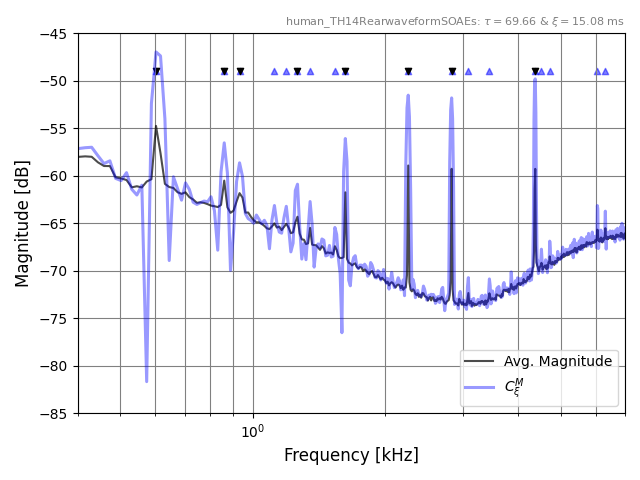

In [43]:
"Figure 4B"
import phaseco as pc
import scipy.io as sio
import os
import matplotlib.pyplot as plt
from helper_funcs import *
import scipy.signal as signal

# Filepaths
data_fp = os.path.join("data", "additional_humans")
wf_fn = "human_TH14RearwaveformSOAEshort"
fig_fp = os.path.join(figures_folder, f"Fig4B.jpg")

# Global Parameters
fs = 44100
tau = 3072
do_filter = True

# Coherence parameters
xi = 665
hop_C = 441
win_meth = {"method": "rho", "rho": 1.0, "win_type": "boxcar"}
# Pure magnitude parameters
hop_mags = 3072
win_mags = 'boxcar'


# Plotting params
s_tri = 20
tri_prop_from_top = 0.1
title= wf_fn[:-4]+": "+r'$ \tau=$'+f'{1000*tau/fs:.2f}'+" & "+r'$ \xi=$'+f'{1000*xi/fs:.2f}'+" ms"
# Offsets to line up noise floors; OK to add this offset because it's a "floating" dB scale
yoff_C_xi_M = -43.5 


# Load wf
wf = sio.loadmat(os.path.join(data_fp, wf_fn))["wf"][:, 0]
# Calc autocoh
f, C_xi_M = pc.get_autocoherence(
    wf, fs, xi, tau, hop=hop_C, nfft=tau, win_meth=win_meth, mode="M", ref_type="time"
)
mags = pc.get_welch(wf, fs, tau, nfft=tau, hop=hop_mags, win=win_mags, avg_exp=1)[1]


# Convert to dB and kHz
C_xi_M = 20 * np.log10(C_xi_M)
mags   = 20 * np.log10(mags)
f = f / 1000

# Get frequencies
mag_freqs, C_freqs = get_human_peak_freqs(wf_fn)
print(f"{len(C_freqs) / len(mag_freqs):.3f} times as many found with C_xi^M")
mag_freqs_idxs = np.argmin((np.abs(f[None, :] - mag_freqs[:, None])), axis=1)
C_freqs_idxs = np.argmin((np.abs(f[None, :] - C_freqs[:, None])), axis=1)

# Set limits
ymin = -85
ymax = -45
xmin = 0.4
xmax = 7

plt.close('all')
plt.subplots
# Plot spectra
plt.plot(f, mags, label="Avg. Magnitude", alpha=0.7, color="k")
plt.plot(f, C_xi_M + yoff_C_xi_M, label=r"$C_\xi^M$", color="blue", alpha=0.4, lw=2.2) 

# Scatter triangles
y_tri = ymax - (ymax-ymin)*tri_prop_from_top
plt.scatter(f[C_freqs_idxs], y_tri*np.ones(len(C_freqs_idxs)), s=s_tri, marker='^', color='blue', alpha=0.5)
plt.scatter(f[mag_freqs_idxs], y_tri*np.ones(len(mag_freqs_idxs)), s=s_tri, marker='v', color='k')
# Set lims and labels
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.ylabel("Magnitude [dB]", fontsize=12)
plt.xlabel("Frequency [kHz]", fontsize=12)
plt.title(title, fontsize=8,loc='right',color=[0.5,0.5,0.5])
plt.legend()
# Set logscale
ax = plt.gca()
ax.set_xscale('log')
# Add grid
plt.grid(True, which="both", ls="-", color='0.5')
plt.tight_layout()
plt.savefig(fig_fp, dpi=dpi, bbox_inches='tight')



# of mag-avgd peaks found = 90 
# of C_xi^M peaks found = 183 
% increase in # of peaks found = 103.33% 


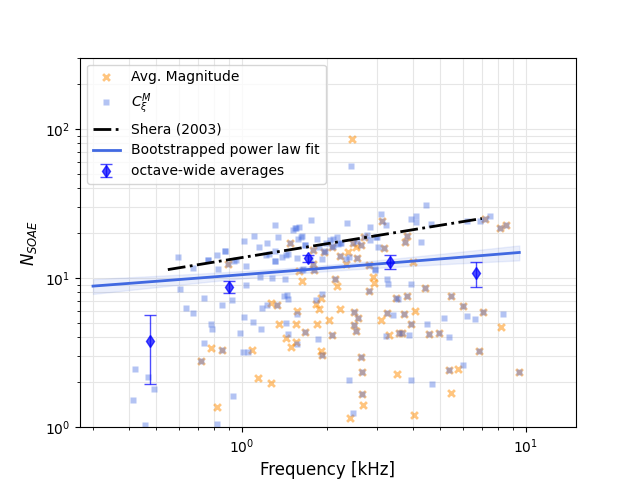

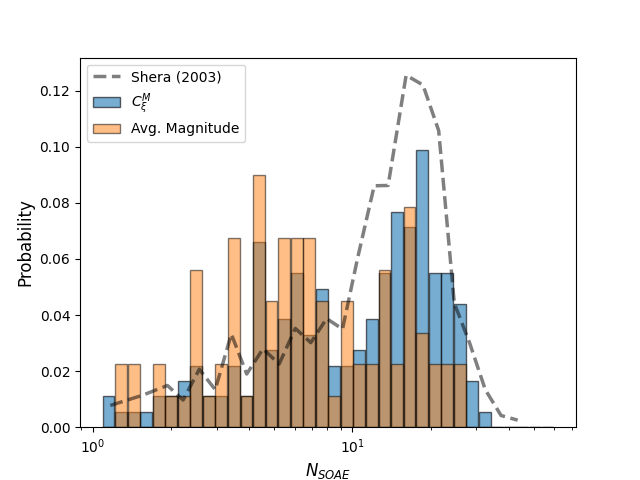

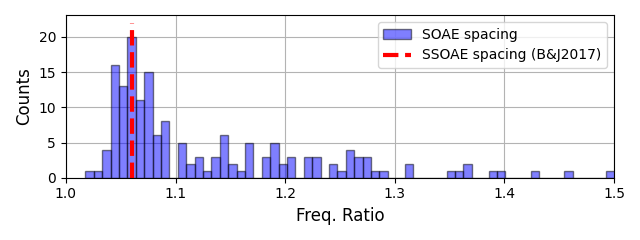

In [44]:
"Figure 4CDE"
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os



# -----------------------------
# function to extract Nsoae and geomean freq from SOAE peak array
def computeNsoae(arr):
    tempARR= arr
    cnt= 0
    M= len(tempARR)  # numb. of peaks
    Mint= M-1   # only consider adjacent peak pairs
    nsoae= np.empty([Mint])
    geofreq= np.empty([Mint])
    # --- only adjacent neighboring pairs
    for nn in range(0,M-1):
        fL= tempARR[nn]*1000 # pick off lowest freq. yet to analyze  [Hz]
        fH= tempARR[nn+1]*1000  # higher freq. of the pair [Hz]
        freqGM= np.sqrt(fH*fL)  # geometric mean freq.
        freqDiff= fH-fL
        geofreq[cnt]= freqGM  # stored geometric mean freq. [Hz]
        nsoae[cnt]= freqGM/freqDiff # stored Nsoae
        cnt= cnt+1
        
    return geofreq, nsoae


"Filepaths"
method_id_N_xi = 'rho=1.0, Flattop, BW=50Hz, Mode=phi'
fp_N_xi= os.path.join('results', 'soae', f'SOAE Results ({method_id_N_xi})', f'SOAE N_xi Fitted Parameters ({method_id_N_xi}).xlsx')
ssheet_fp = os.path.join('results', 'soae', 'Human Peak Picks (Fig.4)', 'Mags vs C_xi_M Picked Peaks.xlsx')

"Build arrays from spreadsheet"
# Load Excel file into two DataFrames
df_mags = pd.read_excel(ssheet_fp, sheet_name='Mags')
df_C = pd.read_excel(ssheet_fp, sheet_name='C_xi_M')
# Get all the filenames
wf_fns = np.array(df_mags.columns.to_list())
N_wfs = len(wf_fns)
# Initialize final arrays to build
all_geofreqs_mags = []
all_geofreqs_C = []
all_Nsoae_mags = []
all_Nsoae_C = []
all_freq_ratios_C = []
each_geofreqs_C = np.empty(shape=(N_wfs), dtype=list)
each_Nsoae_C = np.empty(shape=(N_wfs), dtype=list)
for k, wf_fn in enumerate(wf_fns):
    # Get freqs
    peak_freqs_mags = df_mags[wf_fn].dropna().to_numpy()
    peak_freqs_C = df_C[wf_fn].dropna().to_numpy()
    # Sort by increasing frequency
    peak_freqs_mags = np.sort(peak_freqs_mags)
    peak_freqs_C = np.sort(peak_freqs_C)
    # Compute Nsoae and geometric mean freqs
    geofreqs_mags, Nsoae_mags = computeNsoae(peak_freqs_mags)
    geofreqs_C, Nsoae_C = computeNsoae(peak_freqs_C)
    # Compute freq ratios (higher/lower)
    ratios_C = peak_freqs_C[1:] / peak_freqs_C[:-1]
    # Add to overall lists
    all_geofreqs_mags.extend(geofreqs_mags)
    all_geofreqs_C.extend(geofreqs_C)
    all_Nsoae_mags.extend(Nsoae_mags)
    all_Nsoae_C.extend(Nsoae_C)
    all_freq_ratios_C.extend(ratios_C)
    each_geofreqs_C[k] = geofreqs_C
    each_Nsoae_C[k] = Nsoae_C
# Convert to ndarray
all_geofreqs_mags = np.array(all_geofreqs_mags)
all_geofreqs_C = np.array(all_geofreqs_C)
all_Nsoae_mags = np.array(all_Nsoae_mags)
all_Nsoae_C = np.array(all_Nsoae_C)
all_freq_ratios_C = np.array(all_freq_ratios_C)
# Compute freq diffs
freq_diffs_C= all_geofreqs_C/all_Nsoae_C



"Chris' original plotting code"
# ======================================================
binsN= 37    # number of bins for Nsoae histogram
N = 1000   # number of times to bootstrap re xi-adjusted power law fit
ratioBinCNT= 200   # numb. of bins for freq. ratio histogram
fact= 1/(8*np.pi);  # scaling factor for all Nxi {1/4pi}
show_plots = 1
save_plots = 1
# ======================================================


# --- send some vals to screen for ref
print(f'# of mag-avgd peaks found = {str(len(all_geofreqs_mags))} ')
print(f'# of C_xi^M peaks found = {str(len(all_geofreqs_C))} ')
percent_inc= 100*(len(all_geofreqs_C)-len(all_geofreqs_mags) )/len(all_geofreqs_mags)
print(f'% increase in # of peaks found = {percent_inc:.2f}% ')




# =======================================================================
# ==== Shera 2003 Nsoae vals
# (previously computed for CB 2012 HR paper; vals. extracted from older analysis
# code: ...//Users/pumpkin/Dropbox/Collaborations B/Oldenburg/Analysis/
#    /2014 MoH owl/Analysis/2012 HR human analysis codesModelPredictN2.m

Shera03n=np.array([1.1686,1.5560,1.9393,2.2290,2.5734,2.9629,3.4175,3.9169,
    4.5260,5.2217,6.0284,6.9145,7.9564,9.1602,10.4685,12.1349,13.7273,
   16.1044,18.6965,21.4918,24.6847,28.2800,32.4947,37.3661,43.2892])
Shera03cnt=np.array([4.2852,6.3118,8.2251,5.3621,11.4314,7.3887,18.3734,10.4826,
   15.4564,12.4530,19.4773,16.6705,21.4195,19.3430,33.3050,47.6042,
   47.6622,69.4051,67.4692,58.4829,24.4698,16.6070,7.3961,2.3141,1.3894])




# ------------------------------------------------
# ------------------------------------------------
# --- grab a subset of Nsoae vals above a certain min. val.
# (a la Shera 2003 analysis to "the peak of the distribution [...]
# To reduce bias in the fit"
# NOTE: unless there is a good reason to utilize this set of #s, seems 
# wiser to avoid
NsoaeMIN= 0.75*np.mean(all_Nsoae_C)
gmTthresh= all_geofreqs_C[all_Nsoae_C>NsoaeMIN]
nTthresh= all_Nsoae_C[all_Nsoae_C>NsoaeMIN]


# =======================================================================
# ==== (single) Power Law fit (a la Shera 2003 approach)
# --
def powlawFunc(f,A,c):
    return A*(f**c)

# === do the fits via the  scipy blackbox
# --- standard spectral averaging peak freqs
paramsS, covarS = curve_fit(powlawFunc,all_geofreqs_mags,all_Nsoae_mags)
AfitS, cfitS = paramsS
# --- xi-adjusted temporal averaging peak freqs
paramsT, covarT = curve_fit(powlawFunc,all_geofreqs_C,all_Nsoae_C)
AfitT, cfitT = paramsT
# --- Shera03-style "thresholded" vals.
paramsTthresh, covarTthresh = curve_fit(powlawFunc,gmTthresh,nTthresh)
AfitTthresh, cfitTthresh = paramsTthresh

# ==== compute fit curves to plot
fitF= np.logspace(np.log10(300),np.log10(max(all_geofreqs_C)), 50)
fitNS= powlawFunc(fitF,AfitS, cfitS)
fitNT= powlawFunc(fitF,AfitT, cfitT)
fitNTthresh= powlawFunc(fitF,AfitTthresh, cfitTthresh)
# --- Shera's fit vals (via Table I in 2003 paper)
fitFshera= np.logspace(np.log10(550),np.log10(7000), 50)
fitShera= powlawFunc(fitFshera/1000,13.7,0.31)


# =======================================================================
# ==== (bootstrapped I) Power Law fit --> amongst pooled datas
# [adapting bits from my EXstatBootstrap2.py code]

nbs= len(all_Nsoae_C)
#nbs= int(np.round(0.9*len(nTall)))
indx= np.arange(nbs)  # create array index 

for n in range(0,N):
    # === grab a resampled array 
    indxBS= np.random.choice(indx,replace=1,size=nbs)
    xT= all_geofreqs_C[indxBS] # 
    yT= all_Nsoae_C[indxBS] # 
    pTtemp, covarTtemp = curve_fit(powlawFunc,xT,yT,maxfev=2000)
    AfitTtemp, cfitTtemp = pTtemp
    fitTtemp= powlawFunc(fitF,AfitTtemp, cfitTtemp)
    # -- store away fits
    if n==0:
        yDf= fitTtemp  # kludgy
    else:
        yDf= np.vstack((yDf,fitTtemp)) 

# === determine mean and SD (& SE) from bootstrapped loess      
yDfitM= np.mean(yDf,0)  # mean loess fit
yDfitSD= np.std(yDf,axis=0)  # standard deviation
SE= yDfitSD/np.sqrt(N)  # " standard error
CI= 2*SE # confidence intervals (CIs) as +/-95% (i.e., 2*SE)


# =======================================================================
# ==== (bootstrapped II) Power Law fit --> amongst subjects
# Bootstrap resampling number (equal to number of subjects, 12)
nbs2= len(wf_fns)
# NOTE: can make this smaller if you want fewer resmapled subjects
indx2= np.arange(nbs2)  # create array index 
# --
for mm in range(0,nbs2-1):
    # Get a reproducible rng
    rng = np.random.default_rng(seed=24) 
    # === grab a resampled list of subject
    indxBS2 = rng.choice(indx2, size=nbs2, replace=True)
    xT2= []
    yT2= []
    # --- compile #s together via for loop (better way to do??)
    for nn in range(0,nbs2-1):
        # Replaced Chris' code 
        # xT2= np.concatenate((xT2,eval('gmT'+str(indxBS2[nn]+1))))
        # yT2= np.concatenate((yT2,eval('nT'+str(indxBS2[nn]+1))))
        # with the following equivalent code with my variables
        xT2.extend(each_geofreqs_C[indxBS2[nn]])
        yT2.extend(each_Nsoae_C[indxBS2[nn]])
    xT2 = np.array(xT2)
    yT2 = np.array(yT2)
    
    pTtemp2, covarTtemp2 = curve_fit(powlawFunc,xT2,yT2)
    AfitTtemp2, cfitTtemp2 = pTtemp2
    fitTtemp2= powlawFunc(fitF,AfitTtemp2, cfitTtemp2)
    # -- store away fits
    if mm==0:
        yDf2= fitTtemp2  # kludgy
    else:
        yDf2= np.vstack((yDf2,fitTtemp2))

# === determine mean and SD (& SE) from bootstrapped loess      
yDfitM2= np.mean(yDf2,0)  # mean loess fit
yDfitSD2= np.std(yDf2,axis=0)  # standard deviation
SE2= yDfitSD2/np.sqrt(N)  # " standard error
CI2= 2*SE2 # confidence intervals (CIs) as +/-95% (i.e., 2*SE)


# =======================================================================
# ==== create histogram of Nsoae vals (akin to Fig.2 of Shera 2003)
log_bins = np.logspace(np.log10(all_Nsoae_C.min()), np.log10(all_Nsoae_C.max()),binsN) 
log_binsShera = np.logspace(np.log10(Shera03n.min()), np.log10(Shera03n.max()),len(Shera03n)) 
bin_centers = (log_bins[:-1] + log_bins[1:]) / 2
# --
countsT, binsREP = np.histogram(all_Nsoae_C,log_bins)
countsS, binsREP = np.histogram(all_Nsoae_mags,log_bins)



# =======================================================================
# -- determine average Nsoae vals. in oct.-wide bins (starting at 0.3 kHz)

freqOct= [300,600,1200,2400,4800,9600]  # oct. range bounds

avgN= []
stdN= []
serrN= []
avgGM= []
for pp in range(0,len(freqOct)-1):
    tmp0= len(all_Nsoae_C[np.where(np.logical_and(all_geofreqs_C>=freqOct[pp],all_geofreqs_C<freqOct[pp+1]))])
    tmp1= np.mean(all_Nsoae_C[np.where(np.logical_and(all_geofreqs_C>=freqOct[pp],all_geofreqs_C<freqOct[pp+1]))])
    tmp2= np.std(all_Nsoae_C[np.where(np.logical_and(all_geofreqs_C>=freqOct[pp],all_geofreqs_C<freqOct[pp+1]))])
    tmp3= np.mean(all_geofreqs_C[np.where(np.logical_and(all_geofreqs_C>=freqOct[pp],all_geofreqs_C<freqOct[pp+1]))])
    avgN.append(tmp1)
    stdN.append(tmp2)
    serrN.append(tmp2/np.sqrt(tmp0))
    avgGM.append(tmp3)
    
    
avgN= np.array(avgN)  # kludge
stdN= np.array(stdN)
serrN= np.array(serrN)
avgGM= np.array(avgGM)

#val1= np.mean(nTall[np.where(np.logical_and(gmTall>=300,gmTall<600))])
#std1= np.std(nTall[np.where(np.logical_and(gmTall>=300,gmTall<600))])

# --- also create the assoc. vers. of the freq. diff. from Shera's 2003
# power law fit


fDiffSheraPLoct= np.log2(fitFshera/fitShera)


# =======================================================================
# read in human Nxi vals.


# --- read in data
df = pd.read_excel(fp_N_xi)
human_freqs = df[df['Species'] == 'Human']['Frequency'].values
human_Nxi = df[df['Species'] == 'Human']['N_xi'].values


"Figure 4D"
# =======================================================================
# ==== visualize
plt.close("all")
# ------------------------------------------------
# Fig.4D - Nsoae vs freq. (along with various fits/comps)
fig1, ax1 = plt.subplots()

# --- plot all compiled points
#fig1= plt.plot(gmSall/1000,nSall,'x',color='r',alpha=0.3,ms=5,markerfacecolor='none',label='Spectral Avg.')
fig1= plt.scatter(all_geofreqs_mags/1000,all_Nsoae_mags,marker='x', color='darkorange',s=24,alpha=0.5,linewidths=2,label='Avg. Magnitude')
fig1= plt.plot(all_geofreqs_C/1000,all_Nsoae_C,'s',color='royalblue',alpha=0.4,ms=4,markerfacecolor='royalblue',
               markeredgecolor='none',label=r'$C_\xi^M$')
# --- plot power law fits
#fig1= plt.plot(fitF/1000,fitNS,'r--',lw=1,label='Spectral Avg.')
#fig1= plt.plot(fitF/1000,fitNT,'k-',lw=2,alpha=0.3,label='Power fit (all)')
#fig1= plt.plot(fitF/1000,fitNTthresh,'c-',lw=3,label='Thresholded')
fig1= plt.plot(fitFshera/1000,fitShera,'-.',lw=2,color='black',label='Shera (2003)')
# --- plot bootstrapped power law fits (all data pooled for bootstrap)
fig1= plt.plot(fitF/1000,yDfitM,'-',color='royalblue',lw=2,label='Bootstrapped power law fit')
fig1= plt.fill_between(fitF/1000, (yDfitM-yDfitSD), (yDfitM+yDfitSD), 
                       color='royalblue',alpha=0.1)   
# - Subj.-pooled bootstrapped fit?
if (1==0):
    fig1= plt.plot(fitF/1000,yDfitM2,'-',color='magenta',lw=2,label='Subj.-pooled bootstrapped fit')
    fig1= plt.fill_between(fitF/1000, (yDfitM2-yDfitSD2), (yDfitM2+yDfitSD2), 
                           color='magenta',alpha=0.1)
# --- plot mean oct-wide bin vals?
if (1==1):
    #fig1= plt.plot(avgGM/1000,avgN,'^',color='magenta')
    # --- plotting w/ standard error
    fig1= plt.errorbar(avgGM/1000,avgN, yerr=serrN, fmt='d',capsize=4,lw=1,
                       color='blue',alpha=0.7,label='octave-wide averages')
    

# --- bookeeping
ax1.set_xscale('log')
ax1.set_yscale('log')
fig1= plt.xlim([0.27,15])
fig1= plt.ylim([1,300])
fig1= plt.xlabel('Frequency [kHz]',fontsize=12)
fig1= plt.ylabel(r"$N_{SOAE}$",fontsize=12) 
#fig1= plt.title('Human Nsoae: Spec-avg. (triangle) vs xi-adjust. Temp.-avg. (dot)') 
fig1= plt.grid(True, which="both", ls="-", color='0.9')
ax1.set_axisbelow(True)
fig1= plt.legend()
if show_plots:
    plt.show()
fp = os.path.join(figures_folder, 'Fig4D')
plt.savefig(fp, dpi=dpi, bbox_inches='tight')


"Figure 4C"
# ------------------------------------------------
# Fig.2 - Histogram of Nsoae
fig2, ax2 = plt.subplots()
# ---
plt.bar(bin_centers,countsT/np.sum(countsT),alpha=0.6,width=np.diff(log_bins),ec="k", align="edge",label=rf'$C_\xi^M$')
plt.bar(bin_centers,countsS/np.sum(countsS),alpha=0.5,width=np.diff(log_bins),ec="k",align="edge",label='Avg. Magnitude')
# ----
plt.plot(Shera03n,Shera03cnt/np.sum(Shera03cnt),'k--',lw=2.5,alpha=0.5,label='Shera (2003)')
plt.xscale('log') # Still useful to ensure proper display of log ticks
plt.xlabel(r"$N_{SOAE}$",fontsize=12)
plt.ylabel("Probability",fontsize=12)
#plt.title(r'Comparison of $N_{SOAE}$')
plt.legend()
if show_plots:
    plt.show()
fp = os.path.join(figures_folder, 'Fig4C')
plt.savefig(fp, dpi=dpi, bbox_inches='tight')
    


"Fig 4E"
# ------------------------------------------------
# Purpose: Provide visualization to compare to SSOAE spacings as shown in
# Fig.2 of Bell and Jedrzejczak (2017)
# fig3, ax3 = plt.subplots(2,1)
# ax3[0].plot(all_geofreqs_C/1000,np.log2(all_freq_ratios_C),'bo',ms=3,alpha=0.4)
# ax3[0].set_ylabel("Freq. Pair Spacing [oct]",fontsize=12)
# ax3[0].set_xlabel("Geometric Mean Frequency [kHz]",fontsize=12)
# ax3[0].grid()
plt.figure(figsize=(6.4, 2.4))
ax3 = [0, plt.gca()]
# --
n, bins, patches = plt.hist(all_freq_ratios_C,bins=ratioBinCNT,label='SOAE spacing',
                            color='blue',edgecolor='black',alpha=0.5)
maxCNT = n.max()
ax3[1].plot([1.06,1.06],[0,maxCNT+2],'r--',lw=3,label='SSOAE spacing (B&J2017)')
ax3[1].set_xlim([1,1.5])
ax3[1].set_xlabel("Freq. Ratio",fontsize=12)
ax3[1].set_ylabel("Counts",fontsize=12)
ax3[1].grid(True, which="both", ls="-", color='0.7')
ax3[1].set_axisbelow(True)
ax3[1].legend(loc="upper right")

plt.tight_layout()
if show_plots:
    plt.show()
fp = os.path.join(figures_folder, 'Fig4E')
plt.savefig(fp, dpi=dpi, bbox_inches='tight')

    
    
# ------------------------------------------------
# Fig.4 - Compare human Nsoae versus Nxi
# Purpose: 
if (1==0):
    fig4, ax4 = plt.subplots()
    # ---
    fig4= plt.plot(all_geofreqs_C/1000,all_Nsoae_C,'s',color='royalblue',alpha=0.4,ms=4,markerfacecolor='royalblue',
                   markeredgecolor='none',label=r"$N_{SOAE}$")
    fig4= plt.plot(human_freqs/1000,human_Nxi*fact,'x',color='red',
                   alpha=1,ms=5,markeredgewidth=2,markerfacecolor='none',label=r'$N_{\xi}$')

    ax4.set_xscale('log')
    ax4.set_yscale('log')
    fig4= plt.xlim([0.27,15])
    fig4= plt.ylim([1,300])
    fig4= plt.xlabel('Frequency [kHz]',fontsize=12)
    fig4= plt.ylabel(r"Human $N$ values",fontsize=12) 
    #fig1= plt.title('Human Nsoae: Spec-avg. (triangle) vs xi-adjust. Temp.-avg. (dot)') 
    fig4= plt.grid(True, which="both", ls="-", color='0.9')
    ax4.set_axisbelow(True)
    fig4= plt.legend()
    if show_plots:
        plt.show()